## Prepare the FID for MSE

The following steps are done:
<li> Extract Real contributions
<li> Remove echo points using the derivate (positive values)
<li> Remove points before the peak and normalise the signal   


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown
from astropy.table import Table
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model, Const1D

%matplotlib inline 

def Load_NormFID(File, d_w, suffix='Real_', path_in="", path_out=""):   
    Raw = Table.read(path_in+File, format='ascii.csv')
    Raw['Real'] = True
    #Separate Real and Imaginary 
    odd = np.where(Raw['T'] % 2)
    Raw['Real'][odd] = False  
    even = np.where(Raw['Real'])

    #create new table 
    Data = Table()
    #Convert time ( in s)
    Data['Time'] = Raw['T'][odd] * d_w
    #Compute magnitude ( in s)
    Data['Real'] = Raw['B'][odd] 
    norm = np.max(Data['Real'])
    Data['Real_norm'] = Data['Real'] / norm
    
    pic_region = np.where((Data['Time'] < 0.1))
    signal = np.mean(Data['Real_norm'][pic_region])
    if signal < 0 :
        Data['Real_norm']= -1 * Data['Real_norm']
    File_mag = path_out + suffix + File
    Data.write(File_mag, format='csv',overwrite=True)
    
    return Data

def Remove_badpoints(Data, suffix='MSE_Final_', save_plot=True, plot_name ='Badpoints.png',path_out=""):
    
    #Identify points to erase
    # 1) remove echo
    Data['derv'] = np.gradient(Data['Real_norm'])
    selec_low = np.where((Data['derv'] < 0) & (Data['Time'] < 0.025))
    selec_high = np.where((Data['derv'] > 0) & (Data['Time'] < 0.025))    
    if save_plot : 
        fig, axs = plt.subplots(2, 1)
        plt.figure(figsize=(15,30))
        fig.suptitle(plot_name)
        #plt.figure(1,figsize=(6,6))
        plt.style.use('bmh')
        axs[0].scatter(Data['Time'] , Data['Real_norm'], label="Selected")
        axs[0].set_ylabel('Real norm')
        axs[0].set_xlabel('Time [s]')
        axs[0].scatter(Data['Time'][selec_high] , Data['Real_norm'][selec_high], label="Removed")
        axs[0].legend()
        axs[0].set_xlim(0,0.2)
        
    Data.remove_rows(selec_high) 
  
    # 2)Find max and remove points before the max
    max_id = np.argmax(Data['Real_norm'])
    norm_value = Data['Real_norm'][max_id]
    norm_time = Data['Time'][max_id]
    Data['Real_norm']=Data['Real_norm']/norm_value
    Data.remove_rows(np.where(Data['Time'] < norm_time))
    Data['Time'] = Data['Time'] - norm_time #set first point to t=0
    
    if save_plot : 
    #Plot the cleaned signal
        axs[1].scatter(Data['Time'] , Data['Real_norm'])
        axs[1].set_ylabel('R/R0')
        axs[1].set_xlabel('Time [s]')
        axs[1].set_xlim(0.0,0.2)
        axs[1].set_ylim(0.5,1)
        axs[1].set_yscale('log')
        fig.savefig(path_out+plot_name)
        
    #Save Data
    File_mag = path_out+ suffix + File
    Data.write(File_mag, format='csv',overwrite=True)
    
    return Data
  

IndentationError: expected an indented block (<ipython-input-5-cd9fcf12fbc4>, line 18)

In [9]:
#Change me!
path_in = 'FID_Raw/MSE/'
path_out = 'FID_out/MSE/'

#File = 'fid-tout-mou.txt'
File = '20SCU023-L4=1.txt'
List_File = ['20SCU023-L4=1.txt','20SCU023-L4=2.txt','20SCU023-L4=3.txt','20SCU023-L4=4.txt', '20SCU023-L4=6.txt','20SCU023-L4=8.txt','20SCU023-L4=10.txt','20SCU023-L4=12.txt','20SCU023-L4=14.txt','20SCU023-L4=16.txt','20SCU023-L4=18.txt','20SCU023-L4=20.txt']
d_w = 0.1 /1000.

/Users/lovelace/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


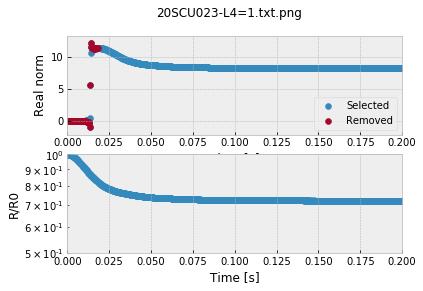

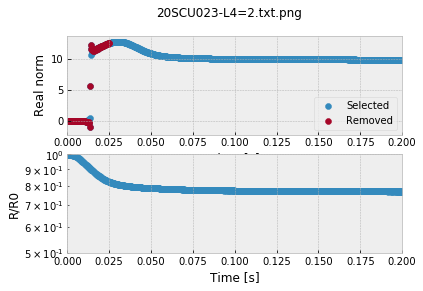

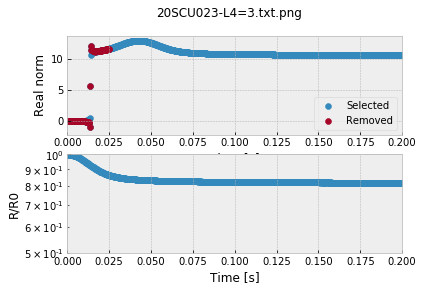

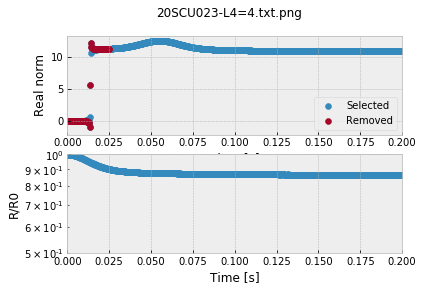

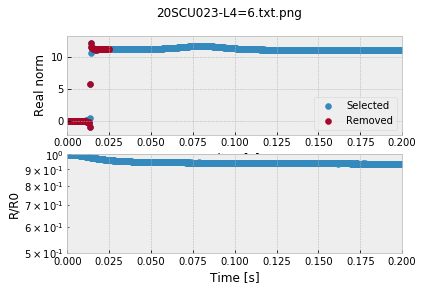

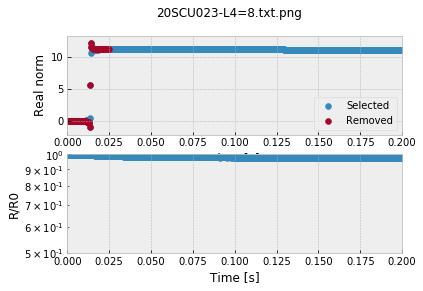

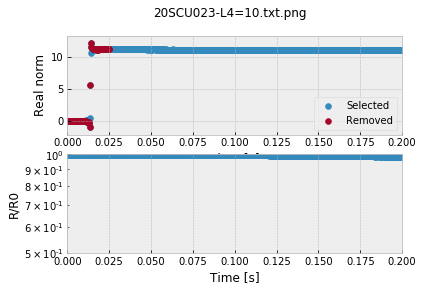

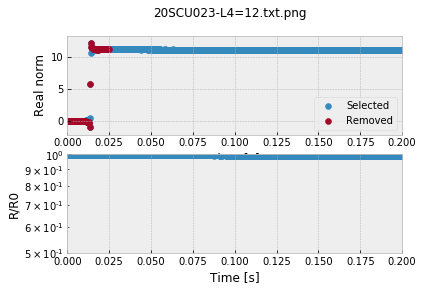

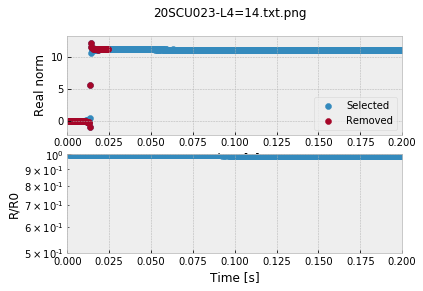

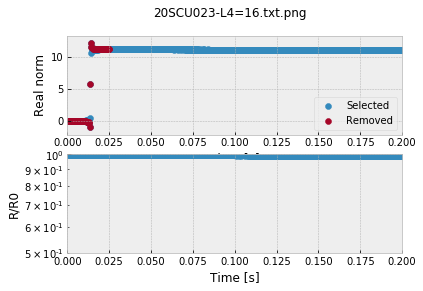

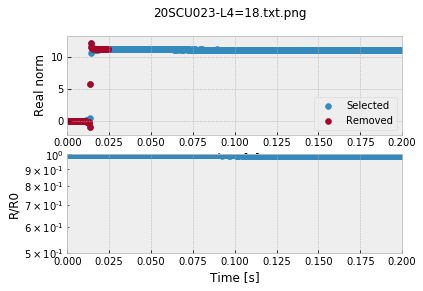

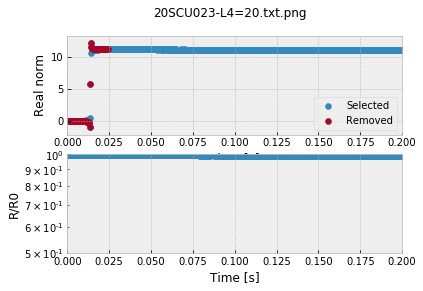

In [10]:
for File in List_File :
    Raw = Load_NormFID(File, d_w, suffix='Real_', path_in = path_in, path_out = path_out)

    Data = Remove_badpoints(Raw, suffix='Final_MSE_', save_plot=True,  plot_name =File+'.png', path_out = path_out)


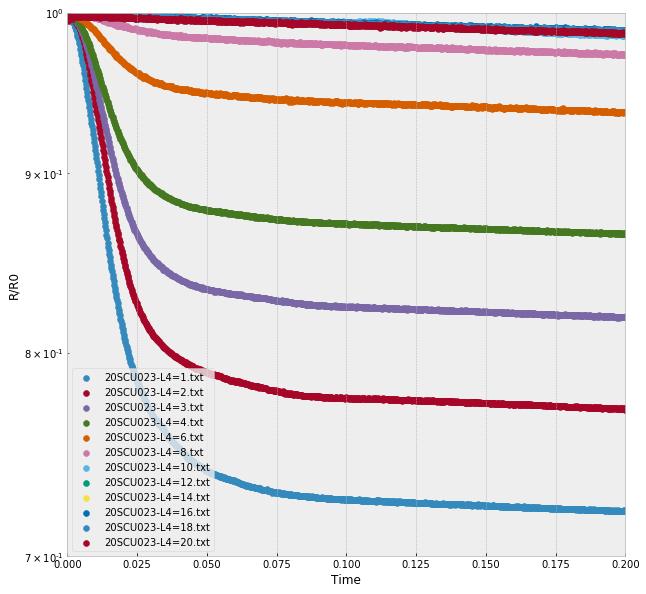

In [12]:
plt.figure(1,figsize=(10,10))

for File in List_File :
  MSE_R = Table.read(path_out+'Final_MSE_'+File, format='ascii.csv')  
  plt.figure(1,figsize=(8,5))
  plt.scatter(MSE_R['Time'],MSE_R['Real_norm'], label=File)
  plt.xlim(0,0.2)
  plt.yscale('log')
  plt.ylim(0.7,1)
plt.xlabel('Time')
plt.ylabel('R/R0')
plt.legend()
plt.savefig(path_out+'_all_'+File[0]+".png")